In [1]:
# Install required packages.
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-geometric
!pip install -q captum

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt

     |████████████████████████████████| 2.6MB 7.0MB/s 
     |████████████████████████████████| 1.5MB 6.8MB/s 
     |████████████████████████████████| 194kB 10.1MB/s 
     |████████████████████████████████| 235kB 13.3MB/s 
     |████████████████████████████████| 2.2MB 13.2MB/s 
     |████████████████████████████████| 51kB 8.7MB/s 
     |████████████████████████████████| 4.4MB 7.8MB/s 


# Explaining GNN Model Predictions using Captum

In this tutorial we demonstrate how to apply feature attribution methods to graphs. Specifically, we try to find the most important edges for each instance prediction.  

We use the Mutagenicity dataset from [TUDatasets](https://chrsmrrs.github.io/datasets/). This dataset consists of 4337 molecule graphs where the task is to predict the molecule mutagenicity.

## Loading the dataset

We load the dataset and use 10% of the data as the test split.

In [2]:
from torch_geometric.data import DataLoader
from torch_geometric.datasets import TUDataset

path = '.'
dataset = TUDataset(path, name='Mutagenicity').shuffle()
test_dataset = dataset[:len(dataset) // 10]
train_dataset = dataset[len(dataset) // 10:]
test_loader = DataLoader(test_dataset, batch_size=128)
train_loader = DataLoader(train_dataset, batch_size=128)

Extracting ./Mutagenicity/Mutagenicity.zip
Processing...
Done!


In [3]:
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Mutagenicity(4337):
Number of graphs: 4337
Number of features: 14
Number of classes: 2

Data(edge_attr=[22, 3], edge_index=[2, 22], x=[11, 14], y=[1])
Number of nodes: 11
Number of edges: 22
Average node degree: 2.00
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


## Visualizing the data

We define some utility functions for visualizing the molecules and draw a random molecule.

In [4]:
import networkx as nx
import numpy as np

from torch_geometric.utils import to_networkx


def draw_molecule(g, edge_mask=None, draw_edge_labels=False):
    g = g.copy().to_undirected()
    node_labels = {}
    for u, data in g.nodes(data=True):
        node_labels[u] = data['name']
    #pos = nx.kamada_kawai_layout(g)
    pos = nx.planar_layout(g)
    pos = nx.spring_layout(g, pos=pos)
    if edge_mask is None:
        edge_color = 'black'
        widths = None
    else:
        edge_color = [edge_mask[(u, v)] for u, v in g.edges()]
        widths = [x * 10 for x in edge_color]
    nx.draw(g, pos=pos, labels=node_labels, width=widths,
            edge_color=edge_color, edge_cmap=plt.cm.Blues,
            node_color='azure')
    
    if draw_edge_labels and edge_mask is not None:
        edge_labels = {k: ('%.2f' % v) for k, v in edge_mask.items()}    
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels,
                                    font_color='red')
    plt.show()


def to_molecule(data):
    ATOM_MAP = ['C', 'O', 'Cl', 'H', 'N', 'F',
                'Br', 'S', 'P', 'I', 'Na', 'K', 'Li', 'Ca']
    g = to_networkx(data, node_attrs=['x'])
    g.remove_nodes_from(list(nx.isolates(g)))

    for u, data in g.nodes(data=True):
        data['name'] = ATOM_MAP[data['x'].index(1.0)]
        del data['x']
    return g


In [5]:
import torch

tr_class1 = torch.cat([data.y for data in train_loader]).sum()
tr_class0 = len(train_dataset) - tr_class1

te_class1 = torch.cat([data.y for data in test_loader]).sum()
te_class0 = len(test_dataset) - te_class1

print(f"Class 1 in tr : {tr_class1} | {tr_class1 / len(train_dataset):.2%}")
print(f"Class 1 in te : {te_class1} | {te_class1 / len(test_dataset):.2%}")

Class 1 in tr : 1738 | 44.52%
Class 1 in te : 198 | 45.73%


## Sample visualization

We sample a single molecule from train_dataset and visualize it

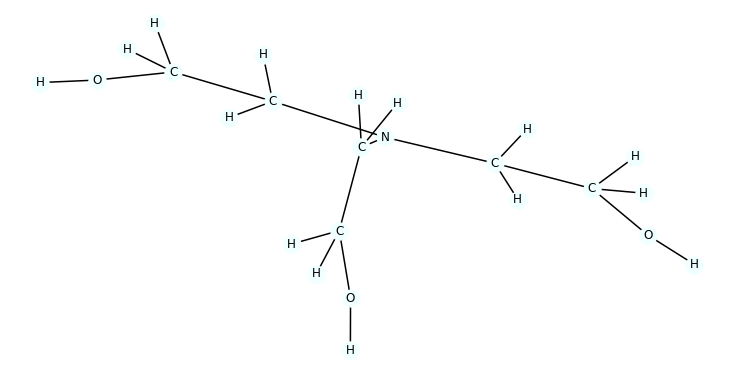

In [6]:
import random

data = random.choice([t for t in train_dataset])
mol = to_molecule(data)
plt.figure(figsize=(10, 5))
draw_molecule(mol)

## Training the model

In the next section, we train a GNN model with 5 convolution layers. We use GraphConv which supports `edge_weight` as a parameter. Many convolution layers in Pytorch Geometric supoort this argument.

### Define the model

In [7]:
import torch
import torch.nn.functional as F
from torch.nn import Linear

from torch_geometric.nn import global_add_pool, GraphConv

class Net(torch.nn.Module):
    def __init__(self, dim):
        super(Net, self).__init__()

        num_features = dataset.num_features
        self.dim = dim

        self.conv1 = GraphConv(num_features, dim)
        self.conv2 = GraphConv(dim, dim)
        self.conv3 = GraphConv(dim, dim)
        self.conv4 = GraphConv(dim, dim)
        self.conv5 = GraphConv(dim, dim)

        self.fc1 = Linear(dim, dim)
        self.fc2 = Linear(dim, dataset.num_classes)

    def forward(self, x, edge_index, batch, edge_weight=None):
        x = F.relu(self.conv1(x, edge_index, edge_weight))
        x = F.relu(self.conv2(x, edge_index, edge_weight))
        x = F.relu(self.conv3(x, edge_index, edge_weight))
        x = F.relu(self.conv4(x, edge_index, edge_weight))
        x = F.relu(self.conv5(x, edge_index, edge_weight))
        x = global_add_pool(x, batch)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)


### Define train and test functions

In [8]:
def train(epoch):
    model.train()

    if epoch == 51:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.5 * param_group['lr']

    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.batch)
        loss = F.nll_loss(output, data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_dataset)


def test(loader):
    model.eval()

    correct = 0
    for data in loader:
        data = data.to(device)
        output = model(data.x, data.edge_index, data.batch)
        pred = output.max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)

### Train the model for 100 epochs

The accuracy should be around 80% in the end

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(dim=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 101):
    train_loss = train(epoch)
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print('Epoch: {:03d}, Train Loss: {:.7f}, '
          'Train Acc: {:.7f}, Test Acc: {:.7f}'.format(epoch, train_loss,
                                                       train_acc, test_acc), end="\r")


## Explaining the predictions

Now we look at two popular attribution methods. First, we calculate the gradient of the output with respect to the edge weights $w_{e_i}$. Edge weights are initially one for all edges.
For the saliency method, we use the absolute value of the gradient as the attribution value for each edge:

$$
Attribution_{e_i} = |\frac{\partial F(x)}{\partial w_{e_i}}|
$$

Where $x$ is the input and $F(x)$ is the output of the GNN model on input $x$.

For Integrated Gradients method, we interpolate between the current input and a baseline input where the weight of all edges is zero and accumulate the gradient values for each edge:

$$
Attribution_{e_i} = \int_{\alpha =0}^1 \frac{\partial F(x_{\alpha)}}{\partial w_{e_i}} d\alpha
$$

Where $x_{\alpha}$ is the same as the original input graph but the weight of all edges is set to $\alpha$. Integrated Gradients complete formulation is more complicated but since our initial edge weights are equal to one and the baseline is zero, it can be simplified to the formulation above. You can read more about this method [here](https://arxiv.org/abs/1703.01365). Of course, this can not be calculated directly and is approximated by a discrete sum.

We use the [captum](https://captum.ai/) library for calculating the attribution values. We define the `model_forward` function which calculates the `batch` argument assuming that we are only explaining a single graph at a time.



In [10]:
from captum.attr import Saliency, IntegratedGradients

def model_forward(edge_mask, data):
    batch = torch.zeros(data.x.shape[0], dtype=int).to(device)
    out = model(data.x, data.edge_index, batch, edge_mask)
    return out


def explain(method, data, target=0):
    input_mask = torch.ones(data.edge_index.shape[1]).requires_grad_(True).to(device)
    if method == 'ig':
        ig = IntegratedGradients(model_forward)
        mask = ig.attribute(input_mask, target=target,
                            additional_forward_args=(data,),
                            internal_batch_size=data.edge_index.shape[1])
    elif method == 'saliency':
        saliency = Saliency(model_forward)
        mask = saliency.attribute(input_mask, target=target,
                                  additional_forward_args=(data,))
    else:
        raise Exception('Unknown explanation method')

    edge_mask = np.abs(mask.cpu().detach().numpy())
    if edge_mask.max() > 0:  # avoid division by zero
        edge_mask = edge_mask / edge_mask.max()
    return edge_mask

Finally we take a random sample from the test dataset and run the explanation methods. For a simpler visualization, we make the graph undirected and merge the explanations of each edge in both directions.

It is known that NO2 substructure makes the molecules mutagenic in many cases and you can verify this by the model explanations.

Mutagenic molecules have label 0 in this dataset and we only sample from those molecules but you can change the code and see the explanations for the other class as well.

In this visualization, edge colors and thickness represent the importance. You can also see the numeric value by passing `draw_edge_labels` to `draw_molecule` function.

As you can see Integrated Gradients tend to create more accurate explanations.

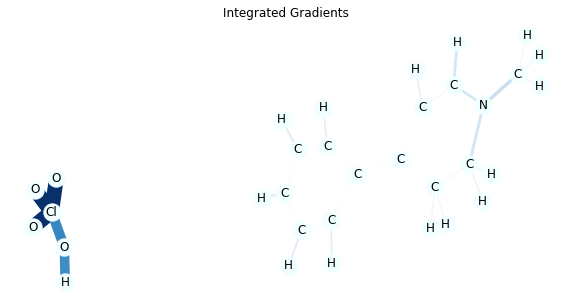

/usr/local/lib/python3.7/dist-packages/captum/_utils/gradient.py:58: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  if input.grad is not None:
/usr/local/lib/python3.7/dist-packages/captum/_utils/gradient.py:87: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  if inpu

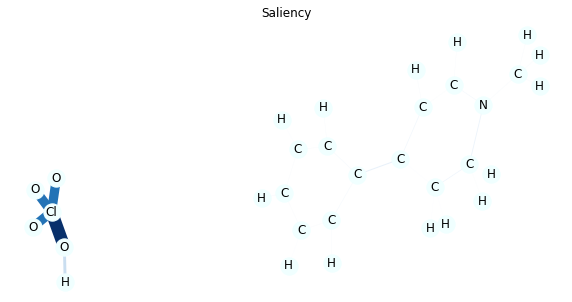

In [12]:
import random
from collections import defaultdict

def aggregate_edge_directions(edge_mask, data):
    edge_mask_dict = defaultdict(float)
    for val, u, v in list(zip(edge_mask, *data.edge_index)):
        u, v = u.item(), v.item()
        if u > v:
            u, v = v, u
        edge_mask_dict[(u, v)] += val
    return edge_mask_dict
    

data = random.choice([t for t in test_dataset if not t.y.item()]).to(device)
mol = to_molecule(data)

for title, method in [('Integrated Gradients', 'ig'), ('Saliency', 'saliency')]:
    edge_mask = explain(method, data, target=0)
    edge_mask_dict = aggregate_edge_directions(edge_mask, data)
    plt.figure(figsize=(10, 5))
    plt.title(title)
    draw_molecule(mol, edge_mask_dict)

In [13]:
from math import sqrt
from copy import deepcopy

import torch
import networkx as nx
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
EPS = 1e-15


class GNNExplainer(torch.nn.Module):
    """The GNN-Explainer model from the `"GNNExplainer: Generating
    Explanations for Graph Neural Networks"
    <https://arxiv.org/abs/1903.03894>`_ paper for identifying compact subgraph
    structures and small subsets node features that play a crucial role in a
    GNN’s graph-prediction.
    """

    coeffs = {
        'edge_size': 0.001,
        'node_feat_size': 1.0,
        'edge_ent': 1.0,
        'node_feat_ent': 0.1,
    }

    def __init__(self, model, epochs=100, lr=0.01, log=True):
        """ Initialize GNNExplainer Class.

        Args:
            model (torch.nn.Module): The GNN module to explain.
            epochs (int, optional): The number of epochs to train.
                (default: :obj:`100`)
            lr (float, optional): The learning rate to apply.
                (default: :obj:`0.01`)
        """
        super(GNNExplainer, self).__init__()
        self.model = model
        self.epochs = epochs
        self.lr = lr
        self.log = log

    def __set_masks__(self, x, edge_index):
        """ Initialize the masks for edges and node features.

        For each module contained in the GNN model, the attribute
        __edge_mask__ is set to the initialized edge mask, so that
        this is automatically taken into account during message passing.

        Args:
            x (torch tensor): node features
            edge_index (torch tensor): pytorch geometric edge index
        """
        (N, F), E = x.size(), edge_index.size(1)

        # Node feature mask.
        self.node_feat_mask = torch.nn.Parameter(torch.randn(F) * 0.1)

        # Edge mask.
        std = torch.nn.init.calculate_gain('relu') * sqrt(2.0 / (2 * N))
        edge_mask = torch.randn(E) * std
        self.edge_mask = torch.nn.Parameter(edge_mask)
        # TODO: at some point we should enforce the mask to be symmetric?
        # Maybe do this iteratively in explain graph? --> but then should
        # maybe reset the module.__edge_mask__ as below

        for module in self.model.modules():
            if isinstance(module, MessagePassing):
                module.__explain__ = True
                module.__edge_mask__ = self.edge_mask

    def __clear_masks__(self):
        """Deletes the node and edge masks.
        """
        for module in self.model.modules():
            if isinstance(module, MessagePassing):
                module.__explain__ = False
                module.__edge_mask__ = None
        self.node_feat_masks = None
        self.edge_mask = None

    def __graph_loss__(self, pred_proba, pred_label):
        """Computes the explainer loss function for explanation
        of graph classificaiton tasks.

        Args:
            pred_proba: predicted probabilities for the different
                classes from the model on the masked input
            pred_label: model prediction on the entire original
                graph (i.e. not masked in features or edges)
        Returns:
            loss (torch.tensor): explainer loss function, which
                is a weight sum of different terms.

        """
        # Prediction loss.
        # TODO: 0 removes the batch dimension? So this works only
        # for batchsize = 1 currently?
        loss = -torch.log(pred_proba[0, pred_label])

        # Edge mask size loss.
        m = self.edge_mask.sigmoid()
        loss = loss + self.coeffs['edge_size'] * m.sum()

        # Edge mask entropy loss.
        ent = -m * torch.log(m + EPS) - (1 - m) * torch.log(1 - m + EPS)
        loss = loss + self.coeffs['edge_ent'] * ent.mean()

        # Feature mask size loss.
        m = self.node_feat_mask.sigmoid()
        loss = loss + self.coeffs['node_feat_size'] * m.mean()

        return loss

    def explain_graph(self, data, **kwargs):
        """Learns and returns a node feature mask and an edge mask that play a
        crucial role to explain the prediction made by the GNN for graph
        classification.

        Args:
            x (Tensor): The node feature matrix.
            edge_index (LongTensor): The edge indices.
            batch_index (LongTensor): The batch index.

            **kwargs (optional): Additional arguments passed to the GNN module.

        Returns:
            (torch.tensor, torch.tensor): the node feature mask and edge mask
        """

        self.model.eval()
        self.__clear_masks__()

        # Get the initial prediction.
        with torch.no_grad():
            model_pred = self.model(data.x ,data.edge_index, data.batch, **kwargs)
            probs_Y = torch.softmax(model_pred, 1)
            pred_label = probs_Y.argmax(dim=-1)

        self.__set_masks__(data.x, data.edge_index)
        self.to(x.device)

        optimizer = torch.optim.Adam([self.node_feat_mask, self.edge_mask],
                                     lr=self.lr)

        epoch_losses = []

        for epoch in range(1, self.epochs + 1):
            epoch_loss = 0
            optimizer.zero_grad()

            # Mask node features
            h = x * self.node_feat_mask.view(1, -1).sigmoid()

            model_pred = self.model(data.x ,data.edge_index, data.batch, **kwargs)
            pred_proba = torch.softmax(model_pred, 1)
            loss = self.__graph_loss__(pred_proba, pred_label)
            loss.backward()
            # print("egde_grad:",self.edge_mask.grad)

            optimizer.step()
            epoch_loss += loss.detach().item()
            # print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
            epoch_losses.append(epoch_loss)

        node_feat_mask = self.node_feat_mask.detach().sigmoid()
        edge_mask = self.edge_mask.detach().sigmoid()

        self.__clear_masks__()

        return node_feat_mask, edge_mask

    def visualize_subgraph(self, data, edge_mask, y=None,
                           threshold=0.5):
        """Visualizes the explanation subgraph.
        Args:
            edge_index (LongTensor): The edge indices.
            edge_mask (Tensor): The edge mask.
            threshold (float): Sets a threshold for visualizing
                important edges.

        Returns:
            (G_original, G_new): two networkx graphs, the original
                one and its subgraph explanation.
        """

        assert edge_mask.size(0) == data.edge_index.size(1)

        # Filter mask based on threshold
        print('Edge Threshold:', threshold)
        edge_mask = (edge_mask >= threshold).to(torch.float)

        subset = set()
        for index, mask in enumerate(edge_mask):
            node_a = edge_index[0, index]
            node_b = edge_index[1, index]
            if node_a not in subset:
                subset.add(node_a.cpu().item())
            if node_b not in subset:
                subset.add(node_b.cpu().item())

        edge_index_new = [[], []]
        for index, edge in enumerate(edge_mask):
            if edge:
                edge_index_new[0].append(data.edge_index[0, index].cpu())
                edge_index_new[1].append(data.edge_index[1, index].cpu())

        # data = Data(edge_index=edge_index.cpu(), att=edge_mask, y=y,
        #             num_nodes=y.size(0)).to('cpu')
        # data_new = Data(edge_index=torch.tensor(edge_index_new).cpu().long(), att=edge_mask, y=y,
        #                 num_nodes=len(subset)).to('cpu')

        data_new = deepcopy(data)
        data_new.edge_index = torch.tensor(edge_index_new)

        mol = to_molecule(data_new)

        draw_molecule(mol)

        print("Removed {} edges -- K = {} remain.".format(data.num_edges -
                                                          data_new.num_edges, data_new.num_edges))
        print("Removed {} nodes -- K = {} remain.".format(data.num_nodes -
                                                          data_new.num_nodes, data_new.num_nodes))

        return mol


In [14]:
loader = DataLoader(dataset, batch_size=1, shuffle=True)
data = next(iter(loader)).to(device)

x = data.x
edge_index = data.edge_index
print(f'Number of nodes: {x.shape[0]}\nNumber of edges: {edge_index.shape[1]}')

Number of nodes: 33
Number of edges: 68


In [15]:
# Initialize explainer
explainer = GNNExplainer(model, epochs=200).to(device)
# Train explainer
feat_mask, edge_mask = explainer.explain_graph(data)

Edge Threshold: 0.75


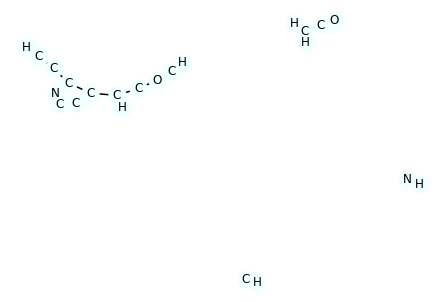

Removed 44 edges -- K = 24 remain.
Removed 0 nodes -- K = 33 remain.


In [16]:
# Visualize explanation subgraph
mol = explainer.visualize_subgraph(data, edge_mask, y=data.y, threshold=0.75)


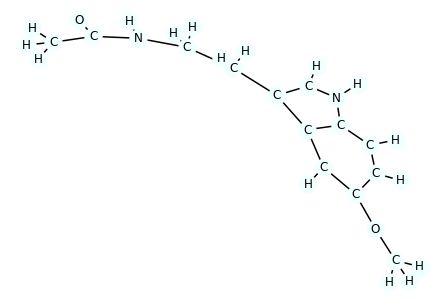

In [17]:
mol0 = to_molecule(data)

draw_molecule(mol0)